**Task 3.Customer Segmentation (Clustering)**

We will cluster customers based on profile and transaction behavior.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import csv

In [ ]:
# Step 1: Load datasets
customers_df = pd.read_csv("Customers.csv")
products_df = pd.read_csv("Products.csv")
transactions_df = pd.read_csv("Transactions.csv")

In [ ]:
# Step 2: Convert date columns to datetime
customers_df["SignupDate"] = pd.to_datetime(customers_df["SignupDate"])
transactions_df["TransactionDate"] = pd.to_datetime(transactions_df["TransactionDate"])

In [ ]:
# Step 3: Aggregate transaction data per customer
customer_transactions = transactions_df.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    total_purchases=("TransactionID", "count"),
    avg_purchase_value=("TotalValue", "mean"),
).reset_index()

In [ ]:
# Step 4: Merge with customer profiles
customer_features = customers_df.merge(customer_transactions, on="CustomerID", how="left").fillna(0)

In [ ]:
# Step 5: Normalize data for similarity and clustering
features = ["total_spent", "total_purchases", "avg_purchase_value"]
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features[features])

In [ ]:
# Step 6: Compute similarity matrix for Lookalike Model
similarity_matrix = cosine_similarity(customer_features_scaled)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features["CustomerID"], columns=customer_features["CustomerID"])

In [ ]:
# Step 7: Find the top 3 similar customers for each customer
lookalike_results = {}
for customer_id in customer_features["CustomerID"]:
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]
    lookalike_results[customer_id] = list(zip(similar_customers.index, similar_customers.values))

In [ ]:
# Step 8: Perform clustering
best_clusters = None
best_score = float("inf")

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(customer_features_scaled)
    db_index = davies_bouldin_score(customer_features_scaled, cluster_labels)
    print(f"Clusters: {k}, DB Index: {db_index}")

    if db_index < best_score:
        best_score = db_index
        best_clusters = cluster_labels

Clusters: 2, DB Index: 1.00343688045421
Clusters: 3, DB Index: 0.9601803766785171
Clusters: 4, DB Index: 0.9070459865008492
Clusters: 5, DB Index: 0.8363561438987264
Clusters: 6, DB Index: 0.8378494162847354
Clusters: 7, DB Index: 0.857634966927223
Clusters: 8, DB Index: 0.9242403350411379
Clusters: 9, DB Index: 0.8867384242626244


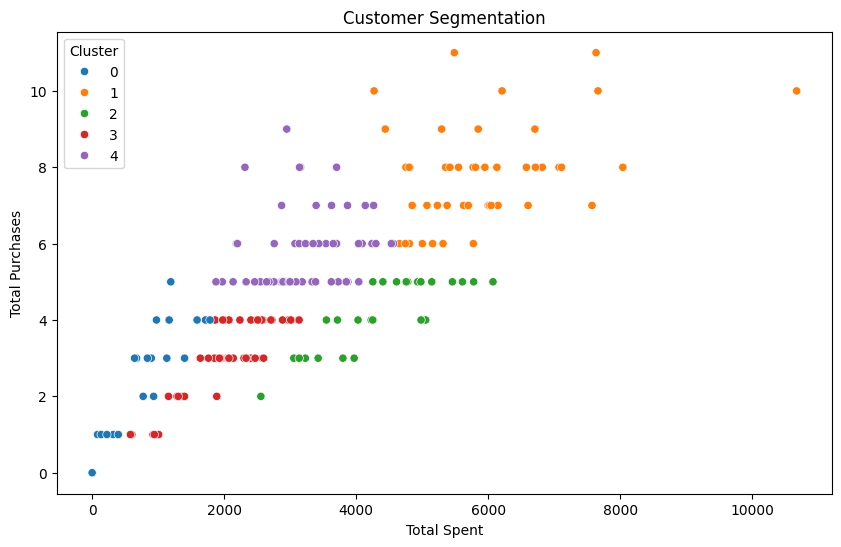

In [ ]:
# Step 9: Assign the best cluster labels to dataset
customer_features["Cluster"] = best_clusters

# Step 10: Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_features["total_spent"], y=customer_features["total_purchases"], hue=customer_features["Cluster"], palette="tab10")
plt.title("Customer Segmentation")
plt.xlabel("Total Spent")
plt.ylabel("Total Purchases")
plt.show()

In [ ]:
# Step 11: Save clustering results
with open("Abhishek_Bitling_Clustering.txt", "w") as file:
    file.write(f"Optimal Clusters: {len(set(best_clusters))}\n")
    file.write(f"DB Index Score: {best_score}\n")
    file.write("Cluster distribution:\n")
    file.write(str(customer_features["Cluster"].value_counts()))